In [1]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

In [2]:
points = 10000
key = jax.random.PRNGKey(seed=42)

<Axes: >

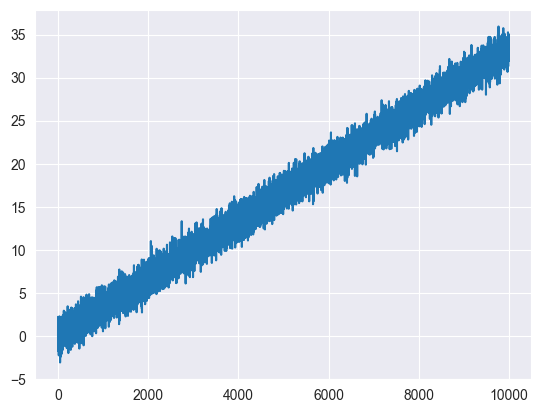

In [3]:
data = jnp.sin(jnp.arange(0, points)) * jnp.cos(jnp.arange(0, points)) + jnp.arange(0, points) * 1/300 + jax.random.normal(key=key, shape=(points,))
sns.lineplot(data)

In [4]:
from lstm import LSTM

In [8]:
LSTM(seed=42, input_dim=1, hidden_dim=1).f_cur(jnp.array([1.]), jnp.array([1.]))

Array([0.7541186], dtype=float32)